## 1- Import neccessary Packages

In [36]:

import pandas as pd
import string
from nltk.corpus import stopwords
from sklearn import model_selection, naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


## 2- Add data as pandas Data Frame
#### in this section, nytimes.csv file is readed as a panda data frame, then category name for each sample is added as new column    

In [37]:
# read nytimes.csv
df = pd.read_csv('nytimes.csv')

In [38]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6207 entries, 0 to 6206
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6207 non-null   int64 
 1   id          6207 non-null   int64 
 2   text        6037 non-null   object
 3   label       6207 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 194.1+ KB


In [39]:
# NY-News lables encoding
lables = {
    0:'Macroeconomics',
    1:'Civil Rights',
    2:'Health',
    3:'Agriculture',
    4:'Labor',
    5:'Education',
    6:'Environment',
    7:'Energy',
    8:'Immigration',
    9:'Transportation',
    10:'Law & Crime',
    11:'Welfare',
    12:'Housing',
    13:'Domestic Commerce',
    14:'Defense',
    15:'Technology',
    16:'Foreign Trade',
    17:'International Affairs',
    18:'Government',
    19:'Public Lands',
    20:'None'
}

In [40]:
#Add New-York news lable, as a new column
for num in lables.keys():
    filt = (df['label'] == num)
    df.loc[filt,'newsCategory'] = lables[num]

In [41]:
df.head()

,Unnamed: 0,id,text,label,newsCategory
0,13198,17116,Scott Brosius returned home at 2 a.m. yesterda...,20,None
1,24713,30994,It's a brisk Wednesday morning in the windy ca...,0,Macroeconomics
2,7139,9132,INTERNATIONAL A3-12,14,Defense
3,12299,16054,The Bush administration is preparing to approv...,6,Environment
4,266,431,With the state facing its potentially worst fi...,20,None


## 3- Remove null values in the text column:
#### in this section null data on the 'text' column of data frame are dropped based on the proportion of them.
#### results stored in a new data frame called 'news'

In [42]:
# null values ratio compared to all values
df['text'].isna().sum()
null_values = (df['text'].isna().sum()/len(df))*100
null_values

2.7388432415015305

### 2.7% contains null values so I could safely ignore those data points

In [43]:
# filtering not null data in a new data frame: 'news'
filt = df['text'].isna()
news = df.loc[~filt, :]

In [44]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6037 entries, 0 to 6206
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    6037 non-null   int64 
 1   id            6037 non-null   int64 
 2   text          6037 non-null   object
 3   label         6037 non-null   int64 
 4   newsCategory  6037 non-null   object
dtypes: int64(3), object(2)
memory usage: 283.0+ KB


## 4- Text Cleaning and Tokenizing:
#### a function is created to remove punctuations, digits, and stopwords from text.
#### a new column is defined in the news data frame called 'tokenized' to store processed texts. 

In [45]:
def textCleaning(text):
    # remove Punctuations and Digits from text
    rmvPuncAndDigit = [char for char in text if (char not in string.punctuation and char not in string.digits)]
    rmvPuncAndDigit = ''.join(rmvPuncAndDigit)
    # Tokenizing text and removing stop words
    tokens = [word.lower() for word in rmvPuncAndDigit.split() if word.lower() not in set(stopwords.words('english'))]
    cleanText = ' '.join(tokens) 
    return cleanText  


In [46]:
# new column tokenized to store processed texts
news['tokenized'] = news['text'].map(textCleaning)

/var/folders/gs/b_ygzg4s6nd75t8lkkpj09gc0000gn/T/ipykernel_6297/4179679863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news['tokenized'] = news['text'].map(textCleaning)


In [47]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6037 entries, 0 to 6206
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    6037 non-null   int64 
 1   id            6037 non-null   int64 
 2   text          6037 non-null   object
 3   label         6037 non-null   int64 
 4   newsCategory  6037 non-null   object
 5   tokenized     6037 non-null   object
dtypes: int64(3), object(3)
memory usage: 330.1+ KB


In [48]:
news.head()

,Unnamed: 0,id,text,label,newsCategory,tokenized
0,13198,17116,Scott Brosius returned home at 2 a.m. yesterda...,20,None,scott brosius returned home yesterday still ov...
1,24713,30994,It's a brisk Wednesday morning in the windy ca...,0,Macroeconomics,brisk wednesday morning windy caverns wall str...
2,7139,9132,INTERNATIONAL A3-12,14,Defense,international
3,12299,16054,The Bush administration is preparing to approv...,6,Environment,bush administration preparing approve clintone...
4,266,431,With the state facing its potentially worst fi...,20,None,state facing potentially worst fiscal crisis y...


## 5- Word Vectorization

In [49]:
TfidfVect = TfidfVectorizer()
x = TfidfVect.fit_transform(news['tokenized'])

In [50]:
print(x)

  (0, 15836)	0.06646929528122372
  (0, 10528)	0.1723415815655626
  (0, 10543)	0.09986016451149529
  (0, 16233)	0.13254803448744024
  (0, 6308)	0.12057735259893312
  (0, 3426)	0.13419391337320039
  (0, 20182)	0.11442072269472173
  (0, 7350)	0.14155309077157954
  (0, 2615)	0.10728445248565714
  (0, 16876)	0.1667600887899077
  (0, 4133)	0.0915536975979885
  (0, 16363)	0.12152256765100188
  (0, 20429)	0.09587171224731471
  (0, 7490)	0.26009997658010087
  (0, 9295)	0.175765145074047
  (0, 12271)	0.16037089967705548
  (0, 15755)	0.12576575190045597
  (0, 7493)	0.20016444675517786
  (0, 11127)	0.20016444675517786
  (0, 18722)	0.19115939047103855
  (0, 5526)	0.1723415815655626
  (0, 6090)	0.20016444675517786
  (0, 12895)	0.19115939047103855
  (0, 17606)	0.10779897437322868
  (0, 20573)	0.07692389788870763
  :	:
  (6035, 11807)	0.08602655090913403
  (6036, 18810)	0.3069169859719288
  (6036, 8288)	0.29310931543882945
  (6036, 17324)	0.26950494675523523
  (6036, 3120)	0.26950494675523523
  (6036,

## 6- Prepare Train and Test Data Sets using a 80/20 training-test split

In [51]:
trainX, testX, trainY, testY = model_selection.train_test_split(x, news['label'], test_size= 0.2)

## 7- Use ML Algorithms
#### three different algorithms are used in this section: 1- Naive Bayes 2- SVM 3- Random Forest
#### for each classifier 4 different score are calculated.
#### the performance of each classifier on every category is provided  

### 7-1- Use the Naive Bayse Algorithms to Predict the outcome

In [52]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(trainX,trainY)
# predict the labels on validation dataset
predictionsNB = Naive.predict(testX)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictionsNB, testY)*100)
# Use precision_score function to get the accuracy
print("Naive Bayes precision Score -> ",precision_score(predictionsNB, testY, average = 'weighted', zero_division= 0)*100)
# Use recall_score function to get the accuracy
print("Naive Bayes Recall Score -> ",recall_score(predictionsNB, testY, average = 'weighted', zero_division= 0)*100)
# Use F1_score function to get the accuracy
print("Naive Bayes F1 Score -> ",f1_score(predictionsNB, testY, average = 'weighted', zero_division= 0)*100)

Naive Bayes Accuracy Score ->  39.32119205298013
Naive Bayes precision Score ->  82.28618489688489
Naive Bayes Recall Score ->  39.32119205298013
Naive Bayes F1 Score ->  49.12004235639129


In [53]:
print(classification_report(testY,predictionsNB, target_names= news['newsCategory'].unique()))

                       precision    recall  f1-score   support

                 None       0.00      0.00      0.00        48
       Macroeconomics       0.00      0.00      0.00        36
              Defense       1.00      0.08      0.16        71
          Environment       0.00      0.00      0.00         6
                Labor       0.00      0.00      0.00        11
               Health       0.00      0.00      0.00        45
    Domestic Commerce       0.00      0.00      0.00        22
International Affairs       0.00      0.00      0.00        13
           Government       0.00      0.00      0.00         6
       Transportation       0.00      0.00      0.00        29
            Education       1.00      0.01      0.02        79
         Civil Rights       0.00      0.00      0.00        14
              Welfare       0.00      0.00      0.00        11
          Agriculture       0.00      0.00      0.00        51
               Energy       0.67      0.55      0.60  

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(89.133125, 0.5, 'predicted label')

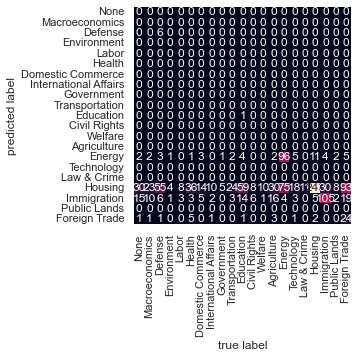

In [59]:
mat = confusion_matrix(testY, predictionsNB)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels = news['newsCategory'].unique(),
            yticklabels= news['newsCategory'].unique())
# Plotting Heatmap of Confusion Matrix
plt.xlabel('true label')
plt.ylabel('predicted label')

### 7-2- Use the SVM Algorithms to Predict the outcome

In [55]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(trainX,trainY)
# predict the labels on validation dataset
predictionsSVM = SVM.predict(testX)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictionsSVM, testY)*100)
# Use precision_score function to get the accuracy
print("SVM precision Score -> ",precision_score(predictionsSVM, testY, average = 'weighted', zero_division= 0)*100)
# Use recall_score function to get the accuracy
print("SVM Recall Score -> ",recall_score(predictionsSVM, testY, average = 'weighted', zero_division= 0)*100)
# Use F1_score function to get the accuracy
print("SVM F1 Score -> ",f1_score(predictionsSVM, testY, average = 'weighted', zero_division= 0)*100)

SVM Accuracy Score ->  57.94701986754966
SVM precision Score ->  67.2627994431755
SVM Recall Score ->  57.94701986754966
SVM F1 Score ->  59.57522724804387


In [56]:
print(classification_report(testY,predictionsSVM, target_names= news['newsCategory'].unique()))

                       precision    recall  f1-score   support

                 None       0.86      0.40      0.54        48
       Macroeconomics       0.80      0.22      0.35        36
              Defense       0.77      0.56      0.65        71
          Environment       0.50      0.17      0.25         6
                Labor       0.33      0.09      0.14        11
               Health       0.84      0.58      0.68        45
    Domestic Commerce       0.83      0.23      0.36        22
International Affairs       0.50      0.08      0.13        13
           Government       0.67      0.33      0.44         6
       Transportation       0.50      0.14      0.22        29
            Education       0.61      0.51      0.55        79
         Civil Rights       1.00      0.50      0.67        14
              Welfare       1.00      0.18      0.31        11
          Agriculture       0.77      0.39      0.52        51
               Energy       0.75      0.65      0.69  

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 7-3- Use the Random Forest Algorithms to Predict the outcome

In [57]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(trainX, trainY)
 
# performing predictions on the test dataset
predictionRF = clf.predict(testX)
# Use accuracy_score function to get the accuracy
print("RF Accuracy Score -> ",accuracy_score(predictionRF, testY)*100)
# Use precision_score function to get the accuracy
print("RF precision Score -> ",precision_score(predictionRF, testY, average = 'weighted', zero_division= 0)*100)
# Use recall_score function to get the accuracy
print("RF Recall Score -> ",recall_score(predictionRF, testY, average = 'weighted', zero_division= 0)*100)
# Use F1_score function to get the accuracy
print("RF F1 Score -> ",f1_score(predictionRF, testY, average = 'weighted', zero_division= 0)*100)

RF Accuracy Score ->  52.06953642384106
RF precision Score ->  63.55366612229706
RF Recall Score ->  52.06953642384106
RF F1 Score ->  55.165398225310916


In [58]:
print(classification_report(testY,predictionRF, target_names= news['newsCategory'].unique()))

                       precision    recall  f1-score   support

                 None       0.72      0.38      0.49        48
       Macroeconomics       0.67      0.06      0.10        36
              Defense       0.70      0.56      0.62        71
          Environment       0.00      0.00      0.00         6
                Labor       0.00      0.00      0.00        11
               Health       0.58      0.62      0.60        45
    Domestic Commerce       1.00      0.09      0.17        22
International Affairs       0.00      0.00      0.00        13
           Government       0.00      0.00      0.00         6
       Transportation       0.62      0.17      0.27        29
            Education       0.61      0.35      0.45        79
         Civil Rights       1.00      0.07      0.13        14
              Welfare       0.00      0.00      0.00        11
          Agriculture       0.56      0.27      0.37        51
               Energy       0.61      0.67      0.64  

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusion and Future work
### In general it looks like due to lack of enough data for some of the lables all the models conclusively dont have prediction power over them. However 
### some models are doing better on low resource setings. for example labor lable in SVM has 100% precision where as Naive Bayse could not detect any samples from this lable.
### at the same time it looks like all of these models have the ability to detect labeles with higher examples.

###  for the next step I would like to experiment:
####    1- spend more time on preprocessing the data such as stemming and lemmatization.
####    2- exclude labales with low resources this might help to more accurately predict for other lables.
####    3-to analyse the length of each data samples and remove samples that are too short. very short sample data can be noise data.
####    4- to up sample, the labels that we dont have enough data. for example we could duplicate and replace some of words with their synonims 